In [1]:
import keras.backend as K
import cv2
import numpy as np
import math
from os.path import dirname, abspath, join

from PIL import Image
import time
import pickle
import sklearn.svm
import configparser

from matplotlib import pyplot as plt
%matplotlib inline

import split
import get_info
from solml import cnn, load


Using TensorFlow backend.


In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')
roof_cache_dir = config['main']['roof_cache_dir']


## Size of images

In [ ]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.two_balanced_classes()
idents = train_ids + val_ids + test_ids
bounding_boxes = get_info.get_bounding_box(idents)
images = load.load_data(idents, bounding_boxes, 5, 5, False) # download

In [ ]:
N = len(ids)
print("%d images"%N)
sizes = np.zeros((N, 2))
for i, ident in enumerate(idents):
    filename = roof_cache_dir + str(ident) + '.jpg'
    image = Image.open(filename)
    x, y = image.size
    sizes[i, 0] = x
    sizes[i, 1] = y

In [ ]:
# plot sizes of images
plt.figure(figsize=(6, 6))
plt.scatter(sizes[:, 0], sizes[:, 1], s=0.5)
plt.axis('equal')
plt.xlim([0,200])
plt.ylim([0,200])
plt.title('Taille des images')
plt.xlabel('x')
plt.ylabel('y')
sizes.mean(axis=0)

## Tests on roof images

In [ ]:
#model.layers[1].W.get_value().shape
#model.layers[29].W.get_value().shape
len(model.layers)

In [ ]:
get_layer_functions = {}
for i in range(len(model.layers)):
    get_layer_functions[i] = K.function([model.layers[0].input],
                                  [model.layers[i].get_output(train=False)])

In [ ]:
three_features = layer_output[0, 4:7, :, :]
three_features = np.swapaxes(three_features, 0, 2)
three_features.shape
plt.imshow(three_features)

In [ ]:
i_layer = 31
lo0 = get_layer_functions[i_layer]([im0])[0]
lo1 = get_layer_functions[i_layer]([im1])[0]

## Use the CNN features to train a classifier

In [3]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.two_balanced_classes()

In [4]:
bounding_boxes = get_info.get_bounding_box(train_ids)
cnn_train = cnn.get_cnn_features_list(train_ids, bounding_boxes)

In [7]:
bounding_boxes = get_info.get_bounding_box(val_ids)
cnn_val = cnn.get_cnn_features_list(val_ids, bounding_boxes)

In [9]:
bounding_boxes = get_info.get_bounding_box(test_ids)
cnn_test = cnn.get_cnn_features_list(test_ids, bounding_boxes)

In [10]:
n_C = 20
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.155831 seconds.
LR took 0.132380 seconds.
LR took 0.178370 seconds.
LR took 0.245096 seconds.
LR took 0.362574 seconds.
LR took 0.535112 seconds.
LR took 0.861922 seconds.
LR took 1.566420 seconds.
LR took 1.878980 seconds.
LR took 1.921146 seconds.
LR took 1.726367 seconds.
LR took 1.839514 seconds.
LR took 1.900964 seconds.
LR took 1.845460 seconds.
LR took 1.851023 seconds.
LR took 1.838386 seconds.
LR took 1.770179 seconds.
LR took 2.410704 seconds.
LR took 1.800407 seconds.
LR took 1.762805 seconds.


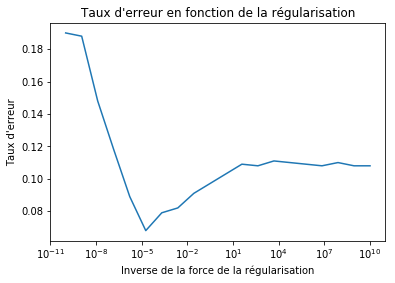

In [11]:
plt.plot(C_list, errors)
plt.title("Taux d'erreur en fonction de la régularisation")
plt.ylabel("Taux d'erreur")
plt.xlabel("Inverse de la force de la régularisation")
plt.xscale('log')

In [12]:
i_opt = np.argmin(errors)
C_opt = C_list[i_opt] #0.000018#
print('optimal C : %f'%C_opt)
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt)
t = time.time()
model.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000018
LR took 0.514211 seconds.


In [13]:
err

0.087999999999999995

In [14]:
cnn_proba_val = model.predict_proba(cnn_val)[:,0]
cnn_proba_test = model.predict_proba(cnn_test)[:,0]

## Visualize some wrong predictions

In [15]:
indexes_wrong = np.where(test_labels!=predictions)[0]

In [18]:
indexes_wrong = np.where(test_labels!=predictions)[0]
def show_wrong():
    i = np.random.choice(indexes_wrong)
    ident = test_ids[i]

    image = np.array(Image.open(roof_cache_dir + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

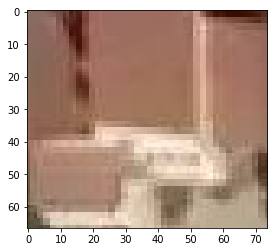

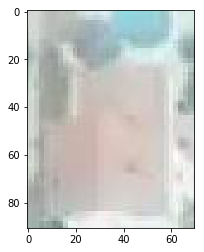

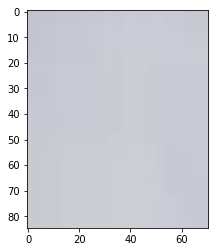

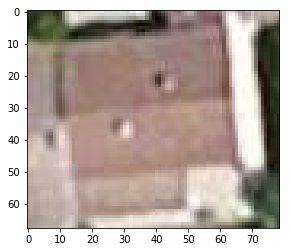

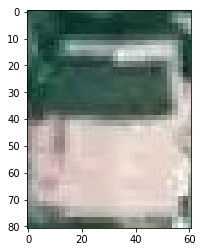

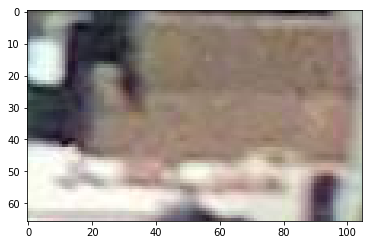

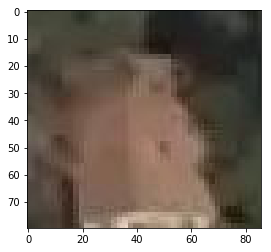

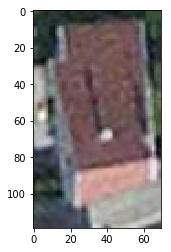

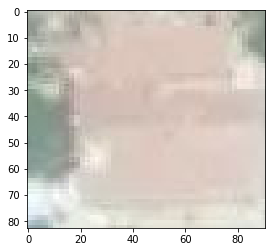

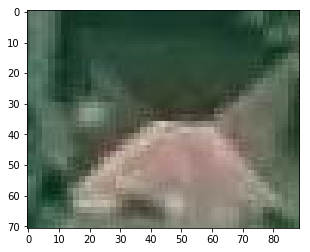

In [19]:
for i in range(10):
    show_wrong()

In [22]:
indexes_right = np.where(test_labels==predictions)[0]
def show_right():
    i = np.random.choice(indexes_right)
    ident = test_ids[i]

    image = np.array(Image.open(roof_cache_dir + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

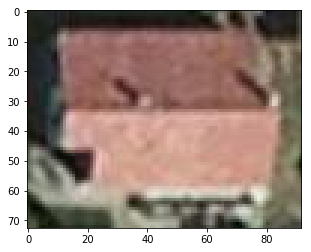

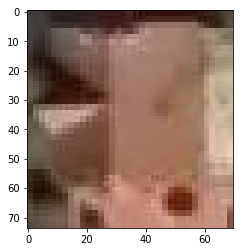

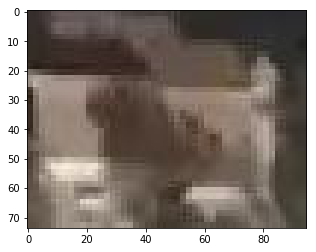

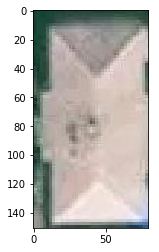

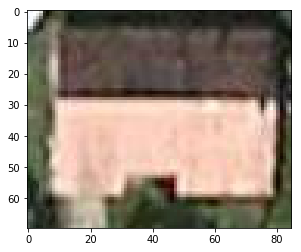

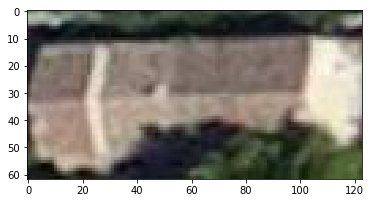

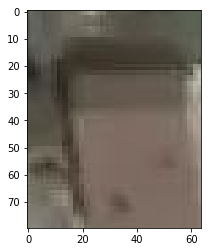

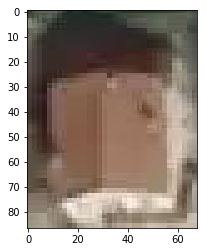

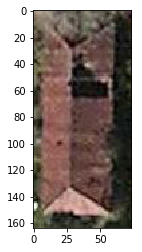

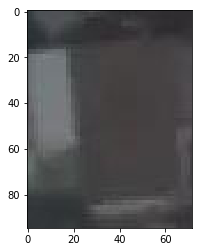

In [23]:
for i in range(10):
    show_right()

# Mix with other features

In [25]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = split.load_images(train_ids, val_ids, test_ids, l, color)

In [26]:
train_ids[0]

'101066942'

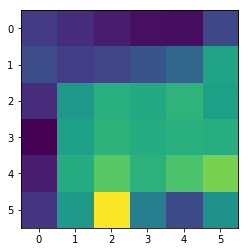

In [27]:
plt.imshow(train_reduc[0].reshape(6, 6), interpolation='none')

In [28]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(train_reduc, train_labels)
predictions = model.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.17699999999999999

In [29]:
reduc_proba_val = model.predict_proba(val_reduc)[:,0]
reduc_proba_test = model.predict_proba(test_reduc)[:,0]

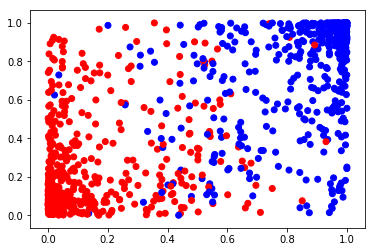

In [30]:
def colorize(labels):
    return ['b' if l==1 else 'r' for l in labels]
plt.scatter(cnn_proba_val, reduc_proba_val, c=colorize(val_labels))

In [31]:
N_val = len(reduc_proba_val)
val_mix = np.zeros((N_val, 2))
val_mix[:, 0] = cnn_proba_val
val_mix[:, 1] = reduc_proba_val
N_test = len(reduc_proba_test)
test_mix = np.zeros((N_test, 2))
test_mix[:, 0] = cnn_proba_test
test_mix[:, 1] = reduc_proba_test

In [32]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(val_mix, val_labels)
predictions = model.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.085000000000000006

In [33]:
probas = model.predict_proba(test_mix)

## Confidence

In [34]:
confidence = np.max(probas, axis=1)

(array([   3.,    0.,    3.,    1.,    1.,    0.,    0.,    2.,    1.,
           1.,    0.,    2.,    3.,    2.,    1.,    1.,    2.,    0.,
           2.,    0.,    3.,    2.,    0.,    1.,    3.,    3.,    2.,
           1.,    0.,    1.,    3.,    3.,    1.,    2.,    0.,    1.,
           3.,    5.,    1.,    3.,    2.,    0.,    2.,    2.,    1.,
           4.,    1.,    3.,    2.,    4.,    3.,    1.,    3.,    1.,
           1.,    5.,    3.,    0.,    0.,    3.,    3.,    0.,    2.,
           3.,    1.,    0.,    3.,    3.,    6.,    3.,    3.,    1.,
           3.,    2.,    1.,    5.,    4.,    5.,    4.,    4.,    4.,
           4.,    1.,    6.,    8.,    4.,    5.,    6.,    7.,    7.,
           9.,   12.,   11.,   13.,   17.,   30.,   50.,   60.,  123.,  463.]),
 array([ 0.50188538,  0.5068408 ,  0.51179621,  0.51675162,  0.52170704,
         0.52666245,  0.53161786,  0.53657328,  0.54152869,  0.5464841 ,
         0.55143952,  0.55639493,  0.56135034,  0.56630576,  0.5

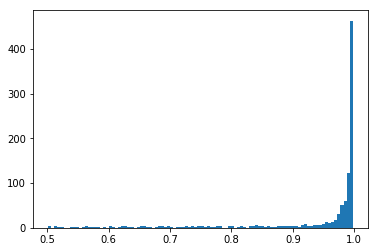

In [35]:
plt.hist(confidence, bins=100)

In [36]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N_test)

/home/michel/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


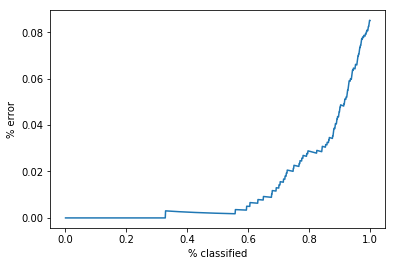

In [37]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [38]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

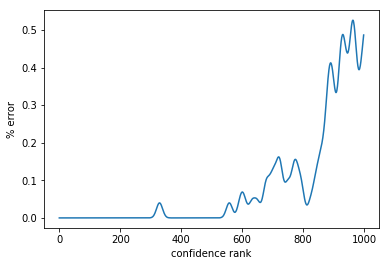

In [39]:
sigma = 10.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')